In [1]:
#bibliotecas utilizadas
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Database
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn import preprocessing

### Parte 1 - Dataset

Ao iniciar qualquer experimento com Inteligência Artificial, o primeiro passo, e um dos mais importantes, é compreender o problema interpretando a base de dados escolhida. Dessa forma, nesta parte deve-se:
* Carregar o dataset
* Analisar os atributos
* Identificar possíveis problemas com a base para preprocessá-la (e.g. identificar duplicadas, outliers, instâncias com atributos incompletos, normalizar e centralizar dados)

In [2]:
def readData(filename, classIndex):
    """ Essa função recebe como parâmetro o nome do arquivo e o índice do atributo alvo.
        Retorno: o dataframe preprocessado e o dataframe contendo apenas a coluna do atributo alvo
    """
    df = pd.read_csv('LasVegasTripAdvisorReviews-Dataset.csv', delimiter=';')
    labelencoder_X = LabelEncoder()
    df = df.apply(LabelEncoder().fit_transform)
    df_classes = df.iloc[:,14]
    #print(df.columns.values)
    df.drop(df.columns[[14]], axis=1, inplace=True)
    return df, df_classes

In [3]:
def visualizeFreq(x, y):
    """Função simples para plotagem de gŕaficos de barra e de linha.
        Utilizou-se essa função para visualizar a frequência das classes e os melhores resultados
        de K.
    """
    width = 0.3
    plt.bar(x, y, width, color="indianred", align='center')
    #plt.plot(freq,colum_values)
    plt.xlabel('Valores de K')
    plt.ylabel('Acurácia')
    plt.show() 

### Parte 2 - Preprocessamento

Para essa base, foram excluídas as colunas 8,9,11 e 12, por terem o mesmo valor para todas as instâncias, e o atributo da coluna 13, referente ao nome do hotel.
Foram testadas três tipos de normalizações, disponíveis na biblioteca preprocessing do  Scikit-learn.

In [4]:
from sklearn import preprocessing

def preprocessingData(df, normalization_type):
    """Entrada: dataframe e tipo de normalização, adicione 'None' neste parâmetro caso
    não queira normalizar.
        Retorna o dataframe preprocessado
    """
    df.drop(df.columns[[8,9,11,12,13]], axis=1, inplace=True)
    if normalization_type == 'scale':
        return preprocessing.scale(df)
    elif normalization_type == 'normalize':
        return preprocessing.normalize(df, axis=0)
    elif normalization_type == 'minmax':
        min_max_scaler = preprocessing.MinMaxScaler()
        return min_max_scaler.fit_transform(df)
    return df

### Parte 3 - Distâncias

Em métodos baseados em distância, um dos passos do algoritmo é calcular a distância entre dois pontos, para isso esse Notebook utiliza três tipos de distância comumente utilizadas:
* Distância Euclidiana: $$d(x,y) = \sqrt{\sum_{l=1}^d(x_l-y_l)^2}$$ 
* Distância Manhattan: $$d(x,y) = \sum_{l=1}^d|x_l-y_l|$$ 
* Distância Minkowski: $$d(x,y) = \sqrt[p]{\sum_{l=0}^{d-l}(|x_l-y_l|)^p}$$ 


In [5]:
def distance(distanceMethod,x,y,p=2):
    """Calcula as distãncias utilizadas, recebe como parâmetros o tipo de distância,
    os atributos de entrada x e o atributo alvo y. O parâmetro p possui um default igual a 2
    e é utilizado apenas para a distância Minkowski.
    Retorno: Array com as distâncias obtidas
    """
    if distanceMethod == 'euclidean':
        return np.sqrt(np.sum((x - y) ** 2,axis=1))
    elif distanceMethod=='manhattan':
        return np.sum(np.abs(x-y),axis=1)
    elif distanceMethod=='minkowski':
        return np.sum(np.abs(x-y)**p,axis=1)**1/p

### Parte 3 - K-NN

Para a implementação do KNN, a distância dos pontos foi calculada através do método distance, ordenada utilizando Numpy e as k maiores distâncias foram armazenadas no vetor de saída.


In [6]:
def train_Knn(X_train,y_train, X_test, k, distance_method):
    """Função de treino do KNN, recebe como parâmetro a base de treino e seus respectivos
    labels, assim como a base de teste, o k desejado e a distância.
    Retorno: array com a predição resultante.
    """
    y_pred=[]
    for i in range(X_test.shape[0]):
        d = distance(distance_method, X_train, X_test[i,:])
        d_sort = np.argsort(d)
        y_n = y_train[d_sort[:k]]
        y_n.dtype
        y_pred.append(np.argmax(np.bincount(y_n)))
    return y_pred

### Parte 4 - Algoritmo Completo e Teste dos Dados

A função KNN recebe o arquivo de entrada e divide-se em três partes principais:
* Leitura e preprocessamento dos arquivos
* Treinamento variando K entre [1,49] apenas para valores ímpares
* Retorno do K que obteve melhor acurácia e análise de métricas do algoritmo (F1, acurácia e matriz de confusão)

In [7]:
def knn(filename):
    df, df_classes = readData(filename,14)
    visualizeFreq(df_classes.unique(),  df_classes.value_counts())
    df = preprocessingData(df,'minmax')
    X_train, X_test, y_train, y_test = train_test_split(df, df_classes.values, test_size=0.33,stratify=df_classes.values)
    acc = []
    for k in range(1,49,2):
        y_pred = train_Knn(X_train, y_train, X_test, k, 'minkowski')
        acc.append(accuracy_score(y_test, y_pred))
    #visualizeFreq(acc, range(1,49,2))
    y_pred_max = np.max(acc)
    y_pred_bestK = np.argmax(acc)
    print('Accuracia:', y_pred_max)
    print('Melhor K:', y_pred_bestK)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

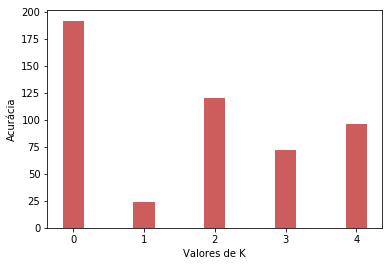

Accuracia: 0.556886227545
Melhor K: 19
             precision    recall  f1-score   support

          0       1.00      0.25      0.40        32
          1       0.52      0.67      0.58        24
          2       0.47      0.20      0.28        40
          3       0.00      0.00      0.00         8
          4       0.53      0.94      0.68        63

avg / total       0.58      0.54      0.48       167

[[ 8  7  3  0 14]
 [ 0 16  2  0  6]
 [ 0  0  8  0 32]
 [ 0  8  0  0  0]
 [ 0  0  4  0 59]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [8]:
knn('LasVegasTripAdvisorReviews-Dataset.csv')